<a href="https://colab.research.google.com/github/abhilashhn1993/Sentiment_Analysis_of_Tweets/blob/master/TFIDF_and_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import nltk; 
nltk.download('stopwords')

In [0]:
!pip install spacy
!pip install pyLDAvis

In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [0]:
print(stop_words)

In [0]:
#remove been, being, haven't, don't, couldn't, didn't
stop_words.remove("i")
stop_words.remove("me")
stop_words.remove("my")
stop_words.remove("don't")
stop_words.remove("been")
stop_words.remove("being")
stop_words.remove("haven't")
stop_words.remove("couldn't")
stop_words.remove("didn't")

In [0]:
#Adding Extra Stopwords to be removed from the dataset
stop_words.extend(['http', 'https', 'twitter', 'www', 'instagram', 'zsgdbw', 'tmblr', 'co', 'twitch','facebook', 'snapchat'])

In [0]:
len(stop_words)

In [0]:
stop_words.extend(['make','really','see','go','would','even','get','com','be','year','still','do','know','actually','much', 'let','s','have','name','photo'])
stop_words.extend(['back','today','day','last','thing','kit','stream','amp'])
stop_words.extend(['trinawolfy','trinawolfy','riyenrootsmusic','straw'])

In [0]:
len(stop_words)

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['All_PTSD_tweets_Flagged.csv']))

In [0]:
df.Ptsd.value_counts()

In [0]:
#Concatenate by username and Ptsd flag variable
df = df[['Username', 'Tweets','Ptsd']]
df1 = df.groupby(['Username','Ptsd'])['Tweets'].agg(' '.join).reset_index(name='Tweets')

In [0]:
df1.iloc[0].Tweets

In [0]:
# Convert to list
df1.Tweets = df1.Tweets.values.tolist()
# Remove Emails
df1.Tweets = [re.sub('\S*@\S*\s?', '', sent) for sent in df1.Tweets]
# Remove new line characters
df1.Tweets = [re.sub('\s+', ' ', sent) for sent in df1.Tweets]
# Remove distracting single quotes
df1.Tweets = [re.sub("\'", "", sent) for sent in df1.Tweets]
pprint(df1.Tweets[:1])

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [0]:
df1.Tweets = list(sent_to_words(df1.Tweets))
print(df1.Tweets[:1])

In [0]:
len(df1.Tweets[0])

In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [0]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
len(df1.Tweets[13])

In [0]:
# Remove Stop Words
df1.Tweets = remove_stopwords(df1.Tweets)

In [0]:
len(df1.Tweets[13])

In [0]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [0]:
# Do lemmatization keeping only noun, adj, vb, adv
df1.Tweets = lemmatization(df1.Tweets, allowed_postags=['NOUN','ADJ','VERB','ADV'])
len(df1['Tweets'])

In [0]:
df1.Tweets = remove_stopwords(df1.Tweets)

In [0]:
#Write the Lammetized data into a CSV file
df1.to_csv('Final_lammetized.csv')

**Creating strlist for tfidf Vectorizer**

In [0]:
#Creating a strlist for tf-idf vectorizer
tweetsList =[]
def listToString(s):
    str1 = " "    
    return (str1.join(s))

In [0]:
for strlist in df1.Tweets:
    strg = listToString(strlist)
    tweetsList.append(strg)
print(tweetsList[0:50])

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
vec = TfidfVectorizer(max_features=10000)

In [0]:
#Putting the tfidf matrix into a pandas dataframe
tfidf_df = pd.DataFrame(data=vec.fit_transform(tweetsList).todense(), columns=vec.get_feature_names())

In [0]:
#Concatenating the original dataset and the tfidf vector matrix for classifier
df2=df1.iloc[:,[0,1]]
df_res = pd.concat([tfidf_df, df2], axis=1, sort=False)

In [0]:
df_res.shape

In [0]:
df_res[:-1]

In [0]:
df_res.iloc[:,10000]

**Train and Test Data split based on 70-30 ratio**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_res.iloc[:,0:9999],df_res['Ptsd'], test_size=0.3, random_state=1)

In [0]:
X_train.shape

(78, 9999)

In [0]:
X_test.shape

(34, 9999)

In [0]:
y_test.shape

(34,)

In [0]:
y_train.shape

(78,)

**LOGISTIC REGRESSION MODEL WITH K-FOLD CROSS VALIDATION**

In [0]:
from sklearn.linear_model.logistic import LogisticRegression
logReg = LogisticRegression()

In [0]:
logReg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score

**Model Validation on the Test data**

In [0]:
scores = cross_val_score(logReg, X_test, y_test, cv=5)

In [0]:
print("Accuracy is", scores.mean()*100, "percent")

Accuracy is 70.47619047619047 percent


In [0]:
predictions = logReg.predict(X_test)

In [0]:
pred_score = logReg.score(X_test, y_test)
print(pred_score*100)

**CONFUSION MATRIX**

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [0]:
conf = metrics.confusion_matrix(y_test, predictions)
print(conf)

[[ 4  6]
 [ 0 24]]


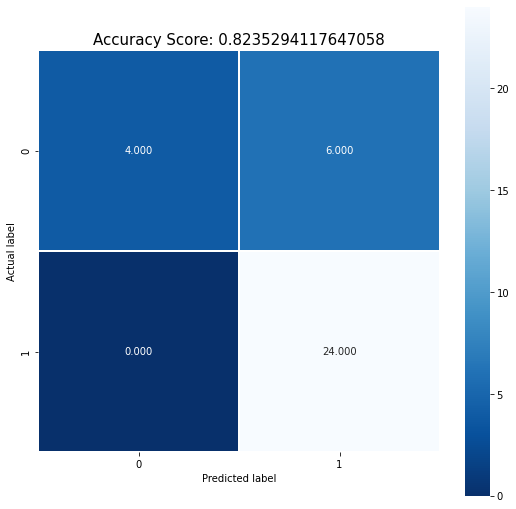

In [0]:
plt.figure(figsize=(9,9))
sns.heatmap(conf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);